* https://fromosia.wordpress.com/2017/03/10/image-orientation-vtk-itk/
* https://nipy.org/nibabel/nifti_images.html

In [ ]:
!pip install nibabel numpy vtk nilearn matplotlib
!sudo apt update && sudo apt install -y libgl1

## Image

In [1]:
import requests

def download_file(url):
    local_filename = url.split('/')[-1]
    local_filename = local_filename.replace(':', '_')
    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
    return local_filename

In [2]:
import nibabel as nib
import numpy as np

url = "http://openneuro.org/crn/datasets/ds001907/snapshots/2.0.3/files/sub-RC4101:ses-1:anat:sub-RC4101_ses-1_T1w.nii.gz"
filename = download_file(url)
img = nib.load(filename)
affine_img = img.affine
print(affine_img)
print(nib.aff2axcodes(affine_img))

[[-1.34386308e-02  0.00000000e+00  9.99909699e-01 -8.69906693e+01]
 [-9.99909699e-01  0.00000000e+00 -1.34386308e-02  1.54644363e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -1.18363998e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
('P', 'S', 'R')


In [3]:
canonical_img = nib.as_closest_canonical(img)
affine = canonical_img.affine
print(affine)
print(nib.aff2axcodes(affine))

[[ 9.99909699e-01  1.34386308e-02  0.00000000e+00 -9.04175201e+01]
 [-1.34386308e-02  9.99909699e-01  0.00000000e+00 -1.00332610e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 -1.18363998e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
('R', 'A', 'S')


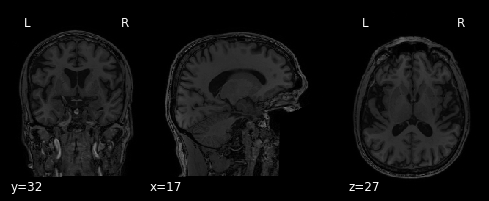

In [4]:
from nilearn.plotting import plot_anat
plot_anat(img, cut_coords=[17, 32, 27], annotate=True, draw_cross=False)

In [5]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 176   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.       1.       1.       1.       0.00767  0.       0.       0.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=3.5;Time=0.000'
aux_file        : b'imgComments'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.49662897
quatern_c       : -0.50334847
quatern_d       : -0.50334847
qoffset_x       : -86.

# Compute transformation matrix

In [6]:
from math import sqrt
header = img.header
#Spacing
s = header['pixdim'][:3]
s = np.array([s[0], s[1], s[2], 1])
 
#Origin (Set this to [0, 0, 0, 1] if you are using itkvtkConnector)
ori = np.array( [header['qoffset_x'], header['qoffset_y'], header['qoffset_z'], 1])
 
'''Directions'''
# Use QForm matrix
if (header['qform_code'] > 0):
    b = header['quatern_b']
    c = header['quatern_c']
    d = header['quatern_d']
    a = sqrt(1 - b*b - c*c - d*d)
    A = np.array([
        [a*a + b*b - c*c - d*d, 2*b*c - 2*a*d, 2*b*d + 2*a*c, ori[0]],
        [2*b*c + 2*a*d, a*a+c*c-b*b-d*d, 2*c*d - 2*a*b, ori[1]],
        [2*b*d - 2*a*c, 2*c*d + 2*a*b, a*a + d*d - c*c - b*b, ori[2]],
        [0, 0, 0, 1]
    ])
    # Obtain user transform for vtk algorithms
    #mat = vtk.vtkMatrix4x4()
    #[[mat.SetElement(i, j, A[i, j]) for i in xrange(4)] for j in xrange(4)]
    print("From qform: \n", A)
    
# Use SForm Matrix
elif (header['sform_code'] > 0):
    gx = header['srow_x']
    gy = header['srow_y']
    gz = header['srow_z']
    # divide SForm matrix by spacing
    gx /= s
    gy /= s
    gz /= s
    A = np.zeros([4,4])
    A[3, 3] = 1
    A[0,:] = gx
    A[1,:] = gy
    A[2,:] = gz
    # Obtain user transform for vtk algorithms
    #mat = vtk.vtkMatrix4x4()
    #[[mat.SetElement(i, j, A[i, j]) for i in xrange(4)] for j in xrange(4)]
    print("From SForm: \n", A)

From qform: 
 [[-1.34387016e-02 -2.43857549e-08 -9.99909704e-01 -8.69906693e+01]
 [-9.99909704e-01 -2.98023224e-08  1.34387205e-02  1.54644363e+02]
 [-2.43857549e-08  1.00000001e+00 -2.98023224e-08 -1.18363998e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


# Transform some ijk points to xyz

In [7]:
from numpy.linalg import inv

header = img.header
for i in [0, header['dim'][1]]:
    for j in [0, header['dim'][2]]:
        for k in [0, header['dim'][3]]:
            ijk = [i, j, k, 1]
            xyz = np.dot(ijk, A.T)
            print("{} -> {}".format(ijk, xyz))

[0, 0, 0, 1] -> [ -86.99066925  154.6443634  -118.36399841    1.        ]
[0, 0, 176, 1] -> [-262.97477711  157.00957822 -118.36400366    1.        ]
[0, 256, 0, 1] -> [-86.99067549 154.64435577 137.63600348   1.        ]
[0, 256, 176, 1] -> [-262.97478335  157.00957059  137.63599824    1.        ]
[256, 0, 0, 1] -> [ -90.43097687 -101.33252075 -118.36400466    1.        ]
[256, 0, 176, 1] -> [-266.41508472  -98.96730594 -118.3640099     1.        ]
[256, 256, 0, 1] -> [ -90.43098311 -101.33252838  137.63599724    1.        ]
[256, 256, 176, 1] -> [-266.41509097  -98.96731357  137.635992      1.        ]


In [8]:
ori

array([ -86.99066925,  154.6443634 , -118.36399841,    1.        ])

In [9]:
point_ijk = [0,0,0,1]
point_xyz = np.dot(point_ijk, A.T)
print("ijk coordinates {} should correspond to image origin {}".format(point_ijk, point_xyz))

ijk coordinates [0, 0, 0, 1] should correspond to image origin [ -86.99066925  154.6443634  -118.36399841    1.        ]


In [10]:
point_ijk = np.dot(point_xyz, inv(A).T)
print("xyz coordinates {} should correspond to image origin {}".format(point_xyz, point_ijk))

xyz coordinates [ -86.99066925  154.6443634  -118.36399841    1.        ] should correspond to image origin [1.35447209e-14 1.42108547e-14 0.00000000e+00 1.00000000e+00]


In [11]:
A[:3,3]

array([ -86.99066925,  154.6443634 , -118.36399841])

In [12]:
np.dot([84,86,120,1], A.T)

array([-208.10868673,   72.26459219,  -32.3640034 ,    1.        ])

In [13]:
np.dot([34.67715964, 40.75661321, 17.26147893,1], inv(A).T)

array([ 112.24240088,  135.6254754 , -123.18734769,    1.        ])

# Vtk

In [14]:
import vtk
from vtkmodules.util import numpy_support

size = header.get_data_shape()
spacing = header.get_zooms()

vtk_array = numpy_support.numpy_to_vtk(np.array(img.dataobj).swapaxes(0, 2).ravel(), 
                                       deep=True, 
                                       array_type=vtk.VTK_INT)
transform = vtk.vtkMatrix4x4()
inv_transform = vtk.vtkMatrix4x4()
[[transform.SetElement(i,j,A[i,j]) for i in range(4)] for j in range(4)]
[[inv_transform.SetElement(i,j,A[i,j]) for i in range(4)] for j in range(4)]
inv_transform.Invert()
direction = vtk.vtkMatrix3x3()
[[direction.SetElement(i,j,A[i,j]) for i in range(3)] for j in range(3)]

volume = vtk.vtkImageData()
volume.SetDimensions(*size)
volume.SetSpacing(spacing)
volume.SetOrigin(*ori[:3])
volume.SetDirectionMatrix(direction)
volume.AllocateScalars(vtk.VTK_INT, 1)
volume.GetPointData().SetScalars(vtk_array)
volume.ComputeBounds()

In [15]:
bounds_xyz = volume.GetBounds()
center_xyz = [bounds_xyz[0] + (bounds_xyz[1]-bounds_xyz[0])/2, 
              bounds_xyz[2]+(bounds_xyz[3]-bounds_xyz[2])/2,
              bounds_xyz[4]+(bounds_xyz[5]-bounds_xyz[4])/2]

print("Volume's bounds: {}".format(bounds_xyz))
print("Center of bounds: {}".format(center_xyz))

Volume's bounds: (-265.4017425370241, -86.99066925048828, -100.33261864721854, 156.99613949509614, -118.36400984685984, 136.6360034766113)
Center of bounds: [-176.1962058937562, 28.33176042393879, 9.135996814875725]


In [16]:
center_ijk = np.dot(center_xyz+[1], inv(A).T)
print("{} should be in the center of slices {}".format(center_ijk, [s/2 for s in size]))

[127.5 127.5  87.5   1. ] should be in the center of slices [128.0, 128.0, 88.0]


In [17]:
out = transform.MultiplyPoint([0,0,0,1])
print("{} should be equal to ori {}".format(out, ori))
out = transform.MultiplyPoint(center_ijk)
print("{} should be equal to center {}".format(out, center_xyz))

(-86.99066925048828, 154.6443634033203, -118.36399841308594, 1.0) should be equal to ori [ -86.99066925  154.6443634  -118.36399841    1.        ]
(-176.19620589375623, 28.331760423938775, 9.13599681487571, 1.0) should be equal to center [-176.1962058937562, 28.33176042393879, 9.135996814875725]


In [18]:
out = inv_transform.MultiplyPoint(center_xyz+[1])
print("{} should be equal to center_ijk {}".format(out, center_ijk))

(127.49999999999999, 127.49999999999997, 87.50000000000003, 1.0) should be equal to center_ijk [127.5 127.5  87.5   1. ]
